In [1]:
import os
import numpy as np
import collections
from statsmodels.stats import multitest
import sys
sys.path.append('../../scripts/')
sys.path.append('../utils/')

import matplotlib.pyplot as plt
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'system', colors='banskt')

import load_results
import precision_recall_scores as roc

INFO_FIELDS = ['rsid', 'stat', 'causality']
class ValidateResult(collections.namedtuple('_ValidateResult', INFO_FIELDS)):
    __slots__ = ()

In [2]:
whichplot = ['tejaas_rrn', 'tejaas_jpa', 'matrixeqtl']

In [3]:
#srcdir = "/scratch/sbanerj/trans-eqtl/simulation/4000_450_20_800_30_150_100_0.01_0.5_0.0_0.1_0.6_4.0_0.1_20_0.02/"
srcdir = "/scratch/sbanerj/trans-eqtl/simulation/15158_450_20_800_30_150_100_0.01_0.0_0.0_1.0_0.6_4.0_0.1_20_0.02/"
perm_sbeta = "0.01"
simlist = list(range(20))
# simlist = [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
# simlist = list(range(5))

def read_data(key, filename, truth):
    valres = list()
    if key == 'jpa':
        for key, value in load_results.jpa_scores(filename).items():
            caus = 1 if key in truth else 0
            valres.append(ValidateResult(rsid = key, stat = value, causality = caus))
    if key == 'meqtl':
        for key, value in load_results.matrixeqtl_fdr(filename).items():
            caus = 1 if key in truth else 0
            valres.append(ValidateResult(rsid = key, stat = value, causality = caus))
    if key == 'rr':
        for key, value in load_results.tejaas(filename).items():
            caus = 1 if key in truth else 0
            valres.append(ValidateResult(rsid = key, stat = value, causality = caus))
    return valres


rdata = dict()
for key in whichplot:
    rdata[key] = [None for x in simlist]

for i, simidx in enumerate(simlist):
    simdir = "sim{:03d}".format(simidx)
    sim_trans_file  = os.path.join(srcdir, simdir, "input/expression.trans")
    sim_cis_file    = os.path.join(srcdir, simdir, "input/expression.cis")
    rr_outfile      = os.path.join(srcdir, simdir, "tejaas/permnull_sb{:s}/rr.txt".format(perm_sbeta))
    rr_randfile     = os.path.join(srcdir, simdir, "tejaas_rand/permnull_sb{:s}/rr.txt".format(perm_sbeta))
    meqtl_outfile   = os.path.join(srcdir, simdir, "matrixeqtl/trans_eqtl.txt")
    meqtl_randfile  = os.path.join(srcdir, simdir, "matrixeqtl_rand/trans_eqtl.txt")
    jpa_outfile     = os.path.join(srcdir, simdir, "tejaas/jpa/all_jpa_pvals.txt")
    jpa_randfile    = os.path.join(srcdir, simdir, "tejaas_rand/jpa/all_jpa_pvals.txt")
    
    true_trans = list()
    with open(sim_trans_file, 'r') as fin:
        for line in (fin):
            linesplit = line.strip().split()
            true_trans.append(linesplit[1])

    if 'tejaas_jpa' in whichplot: rdata['tejaas_jpa'][i] = read_data('jpa', jpa_outfile, true_trans)
    if 'matrixeqtl' in whichplot: rdata['matrixeqtl'][i] = read_data('meqtl', meqtl_outfile, true_trans)
    if 'tejaas_rrn' in whichplot: rdata['tejaas_rrn'][i] = read_data('rr', rr_outfile, true_trans)
    if 'random_jpa' in whichplot: rdata['random_jpa'][i] = read_data('jpa', jpa_randfile, true_trans)
    if 'rand_meqtl' in whichplot: rdata['rand_meqtl'][i] = read_data('meqtl', meqtl_randfile, true_trans)
    if 'random_rrn' in whichplot: rdata['random_rrn'][i] = read_data('rr', rr_randfile, true_trans)

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/sbanerj/trans-eqtl/simulation/15158_450_20_800_30_150_100_0.01_0.0_0.0_1.0_0.6_4.0_0.1_20_0.02/sim010/tejaas/jpa/all_jpa_pvals.txt'

In [4]:
def get_plotvals(res):
    nsim = len(res)
    #print("Number of simulations: {:d}".format(nsim))
    nsel   = [None for x in range(nsim)]
    tpr    = [None for x in range(nsim)]
    ppv    = [None for x in range(nsim)]
    fpr    = [None for x in range(nsim)]
    valids = [None for x in range(nsim)]
    thres  = [None for x in range(nsim)]
    for i in range(nsim):
        #print(i)
        nsel[i], tpr[i], ppv[i], valids[i], thres[i], fpr[i] = roc.confusion_matrix(res[i])
    #print("Number of thresholds: ", [len(x) for x in thres])
    return nsel, tpr, ppv, valids, thres, fpr

def avgplot(ax, xx, yy, label, reverse = False, zoom = 1):
    nsim = len(xx)
    nx = int(2 * np.max([len(x) for x in thres]))
    xmax = int(np.max([max(x) for x in xx]) + 0.5)
    xvals = np.linspace(0, xmax, nx)
    if not reverse:
        yest_arr = np.array([np.interp(xvals, xx[i], yy[i]) for i in range(nsim)])
    else:
        yest_arr = np.array([np.interp(xvals, xx[i][::-1], yy[i][::-1]) for i in range(nsim)])
    yest = np.mean(yest_arr, axis = 0)
    yerr = np.std (yest_arr, axis = 0)
    nplot = int(nx * zoom)
    print(nplot)
    ax.plot(xvals[:nplot], yest[:nplot], label = label)

TEJAAS:
30192
30192
6038
CPMA:
30002
30002
6000


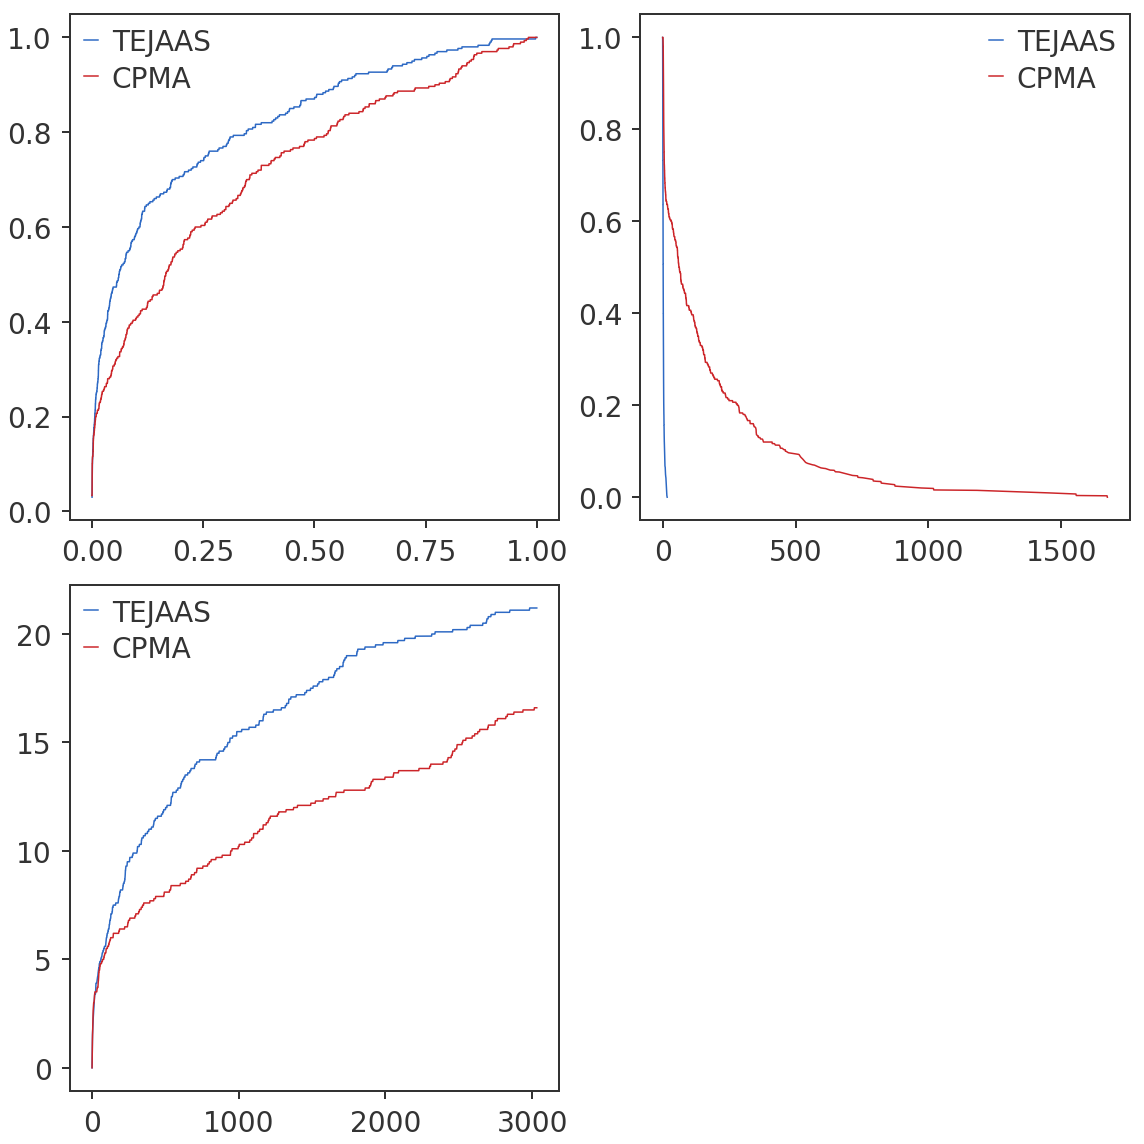

In [5]:
fig = plt.figure(figsize = (16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)

label = {'tejaas_jpa': 'CPMA', 
         'tejaas_rrn': 'TEJAAS', 
         'matrixeqtl': 'MatrixEQTL',
         'random_jpa': 'CPMA (shuffled)',
         'rand_meqtl': 'MatrixEQTL (shuffled)',
         'random_rrn': 'TEJAAS (shuffled)'}

for key in whichplot:
    print('{:s}:'.format(label[key]))
    nsel, tpr, ppv, valids, thres, fpr = get_plotvals(rdata[key])
    avgplot(ax1, fpr, tpr, label[key])
    avgplot(ax2, thres, tpr, label[key], reverse = True)
    avgplot(ax3, nsel, valids, label[key], zoom = 0.2)

#ax1.legend()
#ax1.set_xlim([0, 200])
ax1.legend()
ax2.legend()
ax3.legend()
#ax1.set_xlim([0, 200])
plt.tight_layout()
#plt.savefig(outfile, bbox_inches='tight')
plt.show()

In [12]:
instrs = ["fpr_tpr", "nsel_valids"]

In [13]:
for desc in instrs:
    xstr, ystr = tuple(desc.split('_'))
    print(xstr, ystr)

fpr tpr
nsel valids
